# 1学习任务与数据理解

- 数据来源：
    Arxiv网站存储的1.1TB以上的论文数据集的一个镜像文件，主要存储了论文的  
    - `id`：arXiv ID，可用于访问论文；
  - `submitter`：论文提交者；
  - `authors`：论文作者；
  - `title`：论文标题；
  - `comments`：论文页数和图表等其他信息；
  - `journal-ref`：论文发表的期刊的信息；
  - `doi`：数字对象标识符（DOI号）；
  - `report-no`：报告编号；
  - `categories`：论文在 arXiv 系统的所属类别或标签；
  - `license`：文章的许可证；
  - `abstract`：论文摘要；
  - `versions`：论文版本；
  - `authors_parsed`：作者的信息。

# 2数据导入

In [1]:
# 导入所需的package
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具

In [2]:
data = []

with open('D:/Code/Github/data/arxiv-metadata-oai-snapshot.json','r') as f:
    for idx,line in enumerate(f):
        if idx >= 100:
            break
            
        data.append(json.loads(line))
data = pd.DataFrame(data)
print(data.shape)
data.head()

(100, 14)


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


## 定义文件读取函数

In [3]:
def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi','report-no', 'categories', 'license', 'abstract', 'versions','update_date', 'authors_parsed'], count=None):
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break
                
            d = json.loads(line)
            d = {col : d[col] for col in columns}
            data.append(d)

    data = pd.DataFrame(data)
    return data 

## 截取'id', 'categories', 'update_date'

In [5]:

data = readArxivFile('D:/Code/Github/data/arxiv-metadata-oai-snapshot.json', ['id', 'categories', 'update_date'])

In [7]:
# 查看数据占内存的大小
data.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796911 entries, 0 to 1796910
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   id           object
 1   categories   object
 2   update_date  object
dtypes: object(3)
memory usage: 354.0 MB


# 3数据预处理

## 描述性统计

论文种类描述

In [8]:
data.categories.describe()

count      1796911
unique       62055
top       astro-ph
freq         86914
Name: categories, dtype: object

去重后的论文种类数量

In [9]:
unique_categories = set ( [i for l in [x.split(' ') for x in data.categories] 
for i in l ] )
len(unique_categories)

176

## 截取出2019年的数据

In [11]:
data['year'] = pd.to_datetime(data.update_date).dt.year 
data = data.drop('update_date',axis =1)
data.head()

,id,categories,year
0,0704.0001,hep-ph,2008
1,0704.0002,math.CO cs.CG,2008
2,0704.0003,physics.gen-ph,2008
3,0704.0004,math.CO,2007
4,0704.0005,math.CA math.FA,2013


In [12]:
data = data.loc[data.year >=2019]
data.reset_index(drop = True,inplace = True)
data.tail()

,id,categories,year
395118,quant-ph/9911051,quant-ph,2020
395119,solv-int/9511005,solv-int nlin.SI,2019
395120,solv-int/9809008,solv-int nlin.SI,2019
395121,solv-int/9909010,solv-int adap-org hep-th nlin.AO nlin.SI,2019
395122,solv-int/9909014,solv-int nlin.SI,2019


In [13]:
#爬取所有的类别
website_url = requests.get('https://arxiv.org/category_taxonomy').text #获取网页的文本数据
soup = BeautifulSoup(website_url,'lxml') #爬取数据，这里使用lxml的解析器，加速
root = soup.find('div',{'id':'category_taxonomy_list'}) #找出 BeautifulSoup 对应的标签入口
tags = root.find_all(["h2","h3","h4","p"], recursive=True) #读取 tags

#初始化 str 和 list 变量
level_1_name = ""
level_2_name = ""
level_2_code = ""
level_1_names = []
level_2_codes = []
level_2_names = []
level_3_codes = []
level_3_names = []
level_3_notes = []

#进行
for t in tags:
    if t.name == "h2":
        level_1_name = t.text    
        level_2_code = t.text
        level_2_name = t.text
    elif t.name == "h3":
        raw = t.text
        level_2_code = re.sub(r"(.*)\((.*)\)",r"\2",raw) #正则表达式：模式字符串：(.*)\((.*)\)；被替换字符串"\2"；被处理字符串：raw
        level_2_name = re.sub(r"(.*)\((.*)\)",r"\1",raw)
    elif t.name == "h4":
        raw = t.text
        level_3_code = re.sub(r"(.*) \((.*)\)",r"\1",raw)
        level_3_name = re.sub(r"(.*) \((.*)\)",r"\2",raw)
    elif t.name == "p":
        notes = t.text
        level_1_names.append(level_1_name)
        level_2_names.append(level_2_name)
        level_2_codes.append(level_2_code)
        level_3_names.append(level_3_name)
        level_3_codes.append(level_3_code)
        level_3_notes.append(notes)

#根据以上信息生成dataframe格式的数据
df_taxonomy = pd.DataFrame({
    'group_name' : level_1_names,
    'archive_name' : level_2_names,
    'archive_id' : level_2_codes,
    'category_name' : level_3_names,
    'categories' : level_3_codes,
    'category_description': level_3_notes
    
})

#按照 "group_name" 进行分组，在组内使用 "archive_name" 进行排序
df_taxonomy.groupby(["group_name","archive_name"])
df_taxonomy.head()

,group_name,archive_name,archive_id,category_name,categories,category_description
0,Computer Science,Computer Science,Computer Science,Artificial Intelligence,cs.AI,"Covers all areas of AI except Vision, Robotics..."
1,Computer Science,Computer Science,Computer Science,Hardware Architecture,cs.AR,Covers systems organization and hardware archi...
2,Computer Science,Computer Science,Computer Science,Computational Complexity,cs.CC,"Covers models of computation, complexity class..."
3,Computer Science,Computer Science,Computer Science,"Computational Engineering, Finance, and Science",cs.CE,Covers applications of computer science to the...
4,Computer Science,Computer Science,Computer Science,Computational Geometry,cs.CG,Roughly includes material in ACM Subject Class...


# 数据分析与可视化

In [14]:
data.columns,df_taxonomy.columns

(Index(['id', 'categories', 'year'], dtype='object'),
 Index(['group_name', 'archive_name', 'archive_id', 'category_name',
        'categories', 'category_description'],
       dtype='object'))

In [15]:
df_grouped = data.merge(df_taxonomy,on = 'categories',how = 'left').drop_duplicates(['id','group_name']).groupby('group_name').agg({'id':'count'}).sort_values(by = 'id',ascending = False).reset_index()

In [16]:
df_grouped

,group_name,id
0,Physics,79985
1,Mathematics,51567
2,Computer Science,40067
3,Statistics,4054
4,Electrical Engineering and Systems Science,3297
5,Quantitative Biology,1994
6,Quantitative Finance,826
7,Economics,576


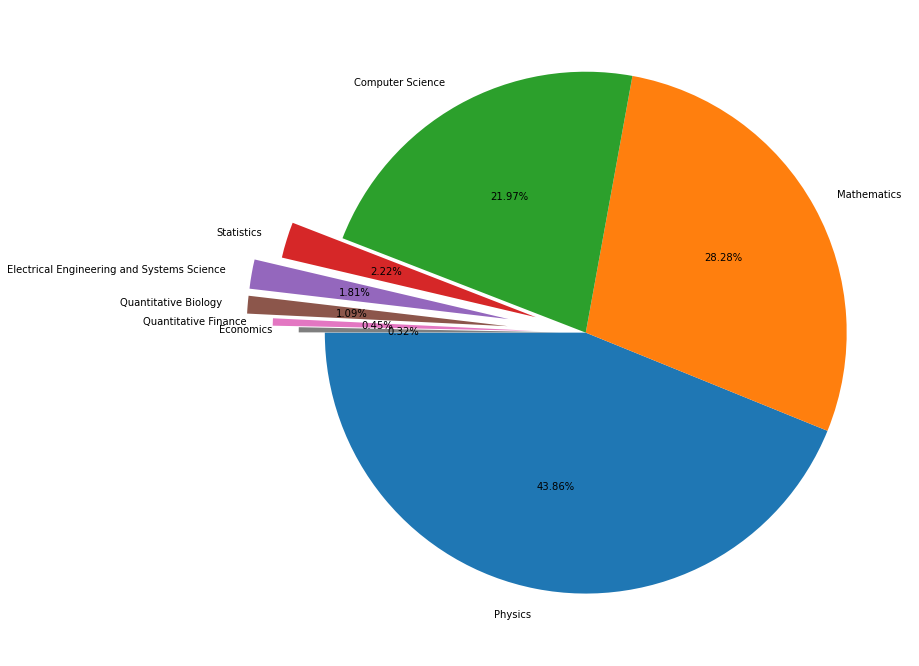

In [18]:
plt.figure(figsize=(15,12))
explode = (0, 0, 0, 0.2, 0.3, 0.3, 0.2, 0.1) 
plt.pie(df_grouped.id,labels=df_grouped.group_name,autopct='%1.2f%%',explode = explode,startangle=180)
plt.show()

In [23]:
group_name="Computer Science"
cats = data.merge(df_taxonomy, on="categories").query("group_name == @group_name")
cats.groupby(["year","category_name"]).count().reset_index().pivot(index="category_name", columns="year",values="id").sort_values(by = 2020,ascending = False)

year,2019,2020
category_name,,
Computer Vision and Pattern Recognition,5559,6517
Computation and Language,2153,2906
Robotics,917,1298
Cryptography and Security,1067,1238
Data Structures and Algorithms,711,902
Software Engineering,659,804
Networking and Internet Architecture,864,783
"Distributed, Parallel, and Cluster Computing",715,774
Artificial Intelligence,558,757
